In [1]:
import pandas as pd
from scipy.io import arff
from scipy.stats.stats import pearsonr
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_selection import chi2
import erlc as e
import dataPipeline as dp
import matplotlib.pyplot as plt
import seaborn as sns
import os

## 1.0 Loading Data and Model Class

In [2]:
dataPipeline = dp.DataPipeline()

In [3]:
data = dataPipeline.loadData(num_sets = 15)

Loading dataset #1
Loading dataset #2
Loading dataset #3
Loading dataset #4
Loading dataset #5
Loading dataset #6
Loading dataset #7
Loading dataset #8
Loading dataset #9
Loading dataset #10
Loading dataset #11
Loading dataset #12
Loading dataset #13
Loading dataset #14
Loading dataset #15
Finished Loading. Final Size = (78377, 129)


In [4]:
X, y = dataPipeline.dataProc(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
erlc = e.ERLC()

## 2.0 Chi Test

In [6]:
final_chi, top_features = erlc.chi_test(X[:,1:X.shape[1]], y)

In [7]:
final_chi

array([[1.47449305e-01, 9.82605491e-01, 7.55320530e-02, ...,
        9.89470876e-01, 7.76614582e-01, 1.00000000e+00],
       [6.12124483e-02, 9.97244118e-01, 4.28035440e-02, ...,
        9.81230943e-01, 9.11362125e-01, 9.05857465e-14],
       [5.11834831e-01, 8.24909217e-01, 1.04090310e-01, ...,
        9.70382352e-01, 8.32261425e-01, 2.58124483e-04],
       ...,
       [8.72548044e-02, 7.05555604e-01, 6.49787863e-02, ...,
        9.77639875e-01, 7.55939898e-01, 9.25961037e-08],
       [2.46568950e-02, 9.93891412e-01, 7.93418073e-02, ...,
        9.72235588e-01, 8.66985171e-01, 1.00000000e+00],
       [1.30519897e-01, 6.09597223e-01, 6.17553492e-05, ...,
        9.75957057e-01, 8.34097111e-01, 1.00000000e+00]])

### 2.1 Heatmap of Chi-test result

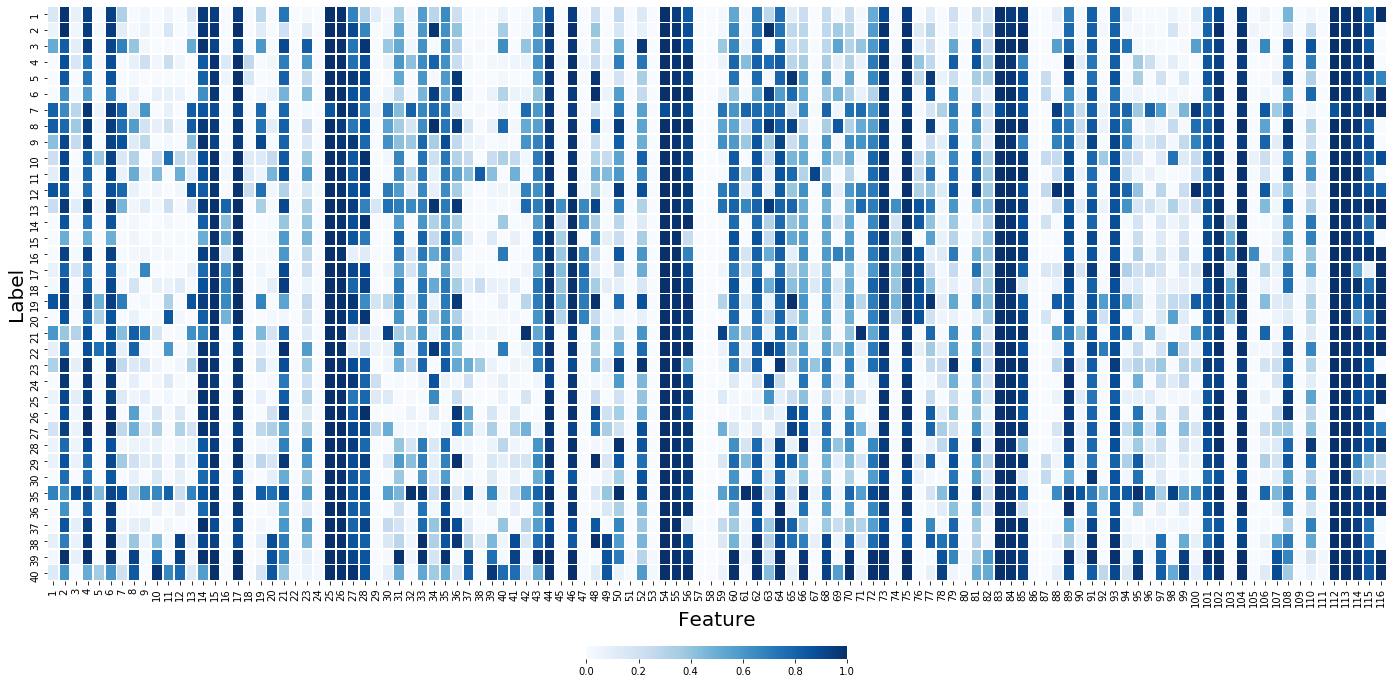

In [33]:
plt.figure(figsize=(24,12))
x_axis_labels = np.unique(y)
x_axis_labels = x_axis_labels[:-1]
y_axis_labels = dataPipeline.getFeatureLabels(data)
sns.heatmap(final_chi,
            xticklabels = range(1,117),
            yticklabels = x_axis_labels,
            cmap="Blues", 
#             center = 0.000001,
            cbar_kws={"shrink": 1, "orientation": "horizontal", "pad": 0.1, "fraction": 0.02},
            linewidths = 0.8)
plt.ylabel("Label", fontsize=20)
plt.xlabel("Feature", fontsize=20)
plt.savefig('output/figures/chi_heatmap.pdf')

In [9]:
top_features

array([[ 85,  52,  56,  79,  86,  50,  44,  73,  57, 108],
       [ 28,  57,  86,  85,  56, 115,  21,  50,  52,  79],
       [ 85,  56,  21,  50,  17,  15,  23,  52,  79, 108],
       [ 28,  57, 110, 108,  86,  85, 115,  56, 102, 104],
       [ 28,   8,  85, 110,  56, 108,  57,  37,  79,  66],
       [ 79,  44,  56,  28,  57,  73,  85,  50,  21,  46],
       [ 57,  86,  56,  85,  44,  17,  15,  21,  23,  50],
       [ 28,  57,  86,  85,  56,  50, 115,  23,  21,  44],
       [ 56,  21,  44,  46,  50,  85,  52,  73,  79, 108],
       [ 28,  21,   2, 110, 108,  57,  50,  79,  85,  56],
       [ 28,  57,  86,  85, 115,  91,  56,  79,   4, 108],
       [ 28,  66,  57,  79,  37,  56,  85, 110, 104, 108],
       [ 66, 104,  37,  57,  86,  17,  85,  50, 102,  56],
       [104,  28,  17,  57,  85,  56,  79,  95,   8,  37],
       [ 17,  57, 104,  86,  85,  75,  56,  46,  28, 115],
       [ 52,  21,  28,  37,  50,  86,  85,  57,  66,  56],
       [ 28,  17,  85,  57,  56, 108,  79, 110,  50,  91

In [10]:
np.unique(top_features[:,0]).shape

(13,)

In [11]:
final_chi2, top_features2 = erlc.chi_test(X[:,np.unique(top_features)], y)

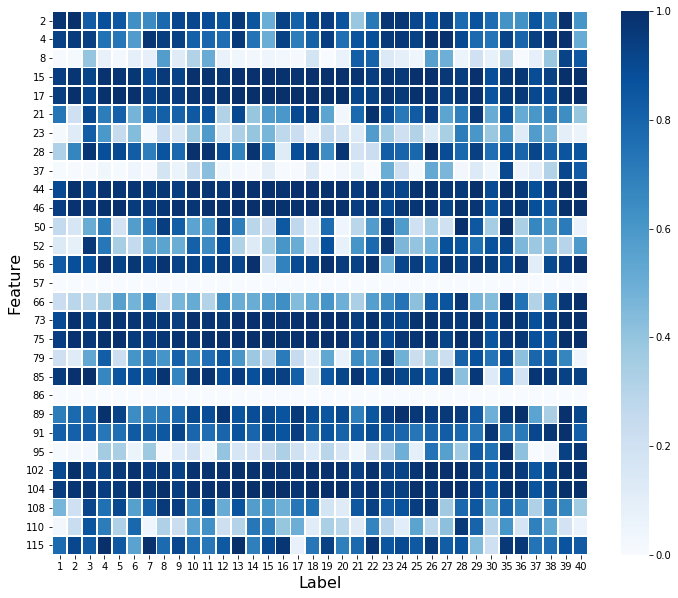

In [12]:
plt.figure(figsize=(12,10))
x_axis_labels = np.unique(y)
x_axis_labels = x_axis_labels[:-1]
sns.heatmap(np.transpose(final_chi2), yticklabels = np.unique(top_features),
            xticklabels = x_axis_labels,
            cmap="Blues", 
#             center = 0.000001,
#             cbar_kws={"shrink": 1, "orientation": "horizontal", "pad": 0.05, "fraction": 0.01},
            linewidths = 0.8)
plt.xlabel("Label", fontsize=16)
plt.ylabel("Feature", fontsize=16)
plt.savefig('output/figures/chi_heatmap_reduced.pdf')

### 2.2 Testing Localization

In [13]:
def localizationTest(X, y, test_split=0.2):
    '''
    This function performs localization test by splitting the data and finding the correlation of the p-values
    from the chi test. 
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_split)
    
    # performing chi test on train and test 
    final_chi_tr, top_features_tr = erlc.chi_test(X_train[:,1:X.shape[1]], y_train)
    final_chi_te, top_features_te = erlc.chi_test(X_test[:,1:X.shape[1]], y_test)
    
    attack_label = 2
    labels = np.unique(y)
    i = 0

    decimals = 4
    corr = []
    attack = []

    for i in range(final_chi_tr.shape[0]):
        temp = pearsonr(final_chi_tr[i],final_chi_te[i])
        temp = round(temp[0], decimals)
        corr.append(temp)
        attack.append(labels[i])
        
    return attack, corr

In [14]:
attack, corr = localizationTest(X, y)

In [15]:
corr_result = pd.DataFrame({
    'Attack Label': attack,
    'Pearson Correlation': corr,
})

# Saving as csv
corr_result.to_csv('output/results_pearsonCorr.csv', index=False)

# Saving as txt for latex table
corr_result.to_csv('output/results_pearsonCorrelation1.txt', sep = '&', index=False)

# Adding "\\" at the end of each line for latex
with open('output/results_pearsonCorrelation1.txt', 'r') as istr:
    with open('output/results_pearsonCorrelation.txt', 'w') as ostr:
        for line in istr:
            line = line.rstrip('\n') + '\\\\'
            print(line, file=ostr)
            
# Remove old file
os.remove('output/results_pearsonCorrelation1.txt') 

Finding the average correlation:

In [43]:
avg_corr = np.mean(corr)
max_corr = np.max(corr)
min_corr = np.min(corr)
labels = np.unique(y)

print("Mean : {}".format(avg_corr))
print("Min: {} for label {}".format(min_corr, labels[np.where(corr==min_corr)] ))
print("Max: {} for label {}".format(max_corr, labels[np.where(corr==max_corr)] ))

Mean : 0.8882333333333333
Min: 0.7574 for label [19]
Max: 0.9675 for label [39]


In [42]:
np.where(corr==min_corr)

(array([18]),)

In [17]:
corr_result.head()

,Attack Label,Pearson Correlation
0,1,0.8594
1,2,0.9504
2,3,0.9296
3,4,0.8935
4,5,0.9664


### 2.3 Average correlation for varying split

In [18]:
splits = np.arange(0.1,0.55,0.05)
averages = []

for split in splits:
    attack, corr = localizationTest(X, y, test_split = split)
    avg_corr = np.mean(corr)
    averages.append(avg_corr)

In [19]:
averages

[0.8152916666666666,
 0.8349638888888888,
 0.8900805555555557,
 0.8972749999999999,
 0.9261388888888887,
 0.9233277777777779,
 0.939897222222222,
 0.9450555555555555,
 0.940463888888889]

In [20]:
avg_result = pd.DataFrame({
    'Split': splits,
    'Average Correlation': averages,
})

avg_result.to_csv('output/results_avgCorrelationPerSplit.csv', index=False)